In [1]:
import pandas as pd
import numpy as np
import os
from utils import base

In [2]:
path = "./tctodd/"
#path = "../../Desktop/MML Project/tctodd/"
dirs = os.listdir(path=path)
weeks = sorted([i for i in dirs if i != ".DS_Store"])
filenames = sorted(os.listdir(path+weeks[1]))

data = []
labels = dict()
label_cnt = 0

for w in weeks:
    temp_path = path+w+"/"
    filenames = sorted(os.listdir(temp_path))
    for fn in filenames:
        label = fn.split('.')[0][:-2]
        
        if label not in labels:
            labels[label] = label_cnt
            label_cnt += 1
            
        data.append({'label':labels[label], 'time_series':pd.read_csv(temp_path+fn, header=None, sep='\t',).values})
        

In [3]:
df = pd.DataFrame(data, columns=['label', 'time_series'])
print(df['label'].value_counts())
df.head()

0     27
60    27
69    27
68    27
67    27
      ..
29    27
28    27
27    27
26    27
94    27
Name: label, Length: 95, dtype: int64


,label,time_series
0,0,"[[-0.064909, 0.034318, -0.043964, 0.626383, 0...."
1,0,"[[-0.107059, -0.126109, -0.053742, 0.612516, 0..."
2,0,"[[-0.061427, -0.082576, -0.102991, 0.735469, 0..."
3,1,"[[-0.128178, 0.02695, -0.050126, 0.455028, 0.4..."
4,1,"[[-0.143672, -0.144416, -0.047447, 0.660979, 0..."


In [4]:
from sklearn.model_selection import train_test_split
X = df['time_series']
y = df['label']
seed = 0
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.222222222222222, random_state=seed)
X_train, X_test = X_train.reset_index(drop=True),X_test.reset_index(drop=True)
y_train, y_test = y_train.reset_index(drop=True), y_test.reset_index(drop=True)

In [5]:
y_train.value_counts()

19    21
23    21
8     21
61    21
44    21
      ..
53    21
9     21
64    21
93    21
94    21
Name: label, Length: 95, dtype: int64

In [6]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA



n_coords = 60
X_interp = base.interpolate_data(X_train, n_coords)
X_interp = base.concatenate_examples(X_interp)


SC = StandardScaler()
SC.fit(X_interp)
X_interp = SC.transform(X_interp)
kpca = KernelPCA(n_components=None, kernel='linear')

principal_comps = kpca.fit_transform(X_interp)
explained_variance = np.var(principal_comps, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

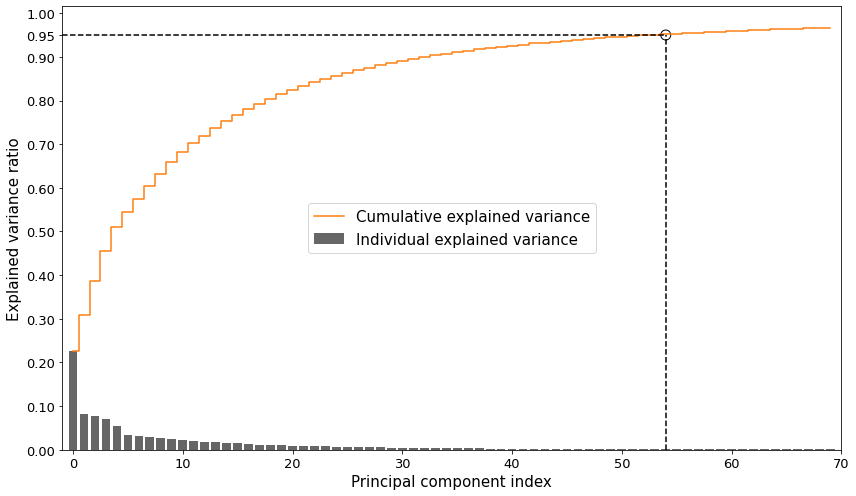

In [77]:
import matplotlib.pyplot as plt
cum_sum_eigenvalues = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(12,7))

plt.bar(range(0,len(explained_variance_ratio[:70])), explained_variance_ratio[:70], alpha=0.6, align='center', label='Individual explained variance', color='k')
plt.step(range(0,len(cum_sum_eigenvalues[:70])), cum_sum_eigenvalues[:70], where='mid',label='Cumulative explained variance', color='tab:orange')
plt.scatter(54,.95, color='tab:red', s=100, edgecolors='k', facecolors='none')
plt.hlines(y=.95, xmin=-1, xmax=54, linestyles='--', colors='k')
plt.vlines(x=54, ymin=0,ymax=0.95, linestyles='--', colors='k')
x_ticks = list(np.linspace(0,1,endpoint=True, num=11))
x_ticks.append(.95)

plt.ylabel('Explained variance ratio', fontsize=15)
plt.xlabel('Principal component index', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(sorted(x_ticks), fontsize=13)
plt.xlim(-1,70)
plt.legend(loc=10, fontsize=15)
plt.tight_layout()
plt.savefig("../images/screeplot.png", format='png', dpi=300)
plt.show()

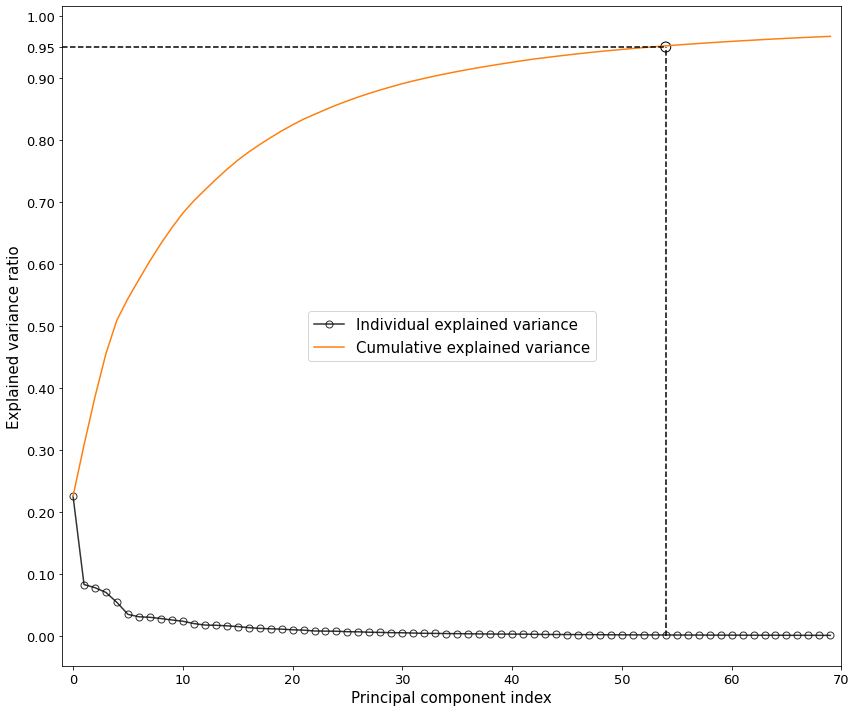

In [74]:
'''
import matplotlib.pyplot as plt
cum_sum_eigenvalues = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(12,10))

plt.plot(range(0,len(explained_variance_ratio[:70])), explained_variance_ratio[:70], linestyle='-', alpha=0.8, marker='o', fillstyle='none', label='Individual explained variance', markersize=7, color='k')
plt.plot(range(0,len(cum_sum_eigenvalues[:70])), cum_sum_eigenvalues[:70],label='Cumulative explained variance', fillstyle='none', color='tab:orange')
plt.scatter(54,.95, color='tab:red', s=100, edgecolors='k', facecolors='none')
plt.hlines(y=.95, xmin=-1, xmax=54, linestyles='--', colors='k')
plt.vlines(x=54, ymin=0,ymax=0.95, linestyles='--', colors='k')
x_ticks = list(np.linspace(0,1,endpoint=True, num=11))
x_ticks.append(.95)

plt.ylabel('Explained variance ratio', fontsize=15)
plt.xlabel('Principal component index', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(sorted(x_ticks), fontsize=13)
plt.xlim(-1,70)
plt.legend(loc=10, fontsize=15)
plt.tight_layout()
plt.savefig("../images/screeplot.png", format='png', dpi=300)
plt.show()
'''

In [19]:
print(f'first 54 dims {cum_sum_eigenvalues[53]} var explained')

first 54 dims 0.9511070637497042 var explained


In [8]:
import sklearn as sk
n_folds = 5
skf = sk.model_selection.StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

In [59]:

import itertools
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from tqdm import tqdm
seed = 0





n_pcs = 54
n_coords = 60

##LINEAR KERNEL
params = [['linear'], [0.0001, 0.0005, 0.001, 0.005, 0.01, 1]]
params_comb = list(itertools.product(*params))
##RBF KERNEL
params = [['rbf'], [0.0001, 0.0005, 0.001, 0.005, 0.01, 1], [0.001, 0.01, 1, 2, 5, 10]]
params_comb += list(itertools.product(*params))
##POLYNOMIAL KERNEL
params = [['poly'], [0.0001, 0.0005, 0.001, 0.005, 0.01, 1], [0.001, 0.01, 1, 2, 5, 10], [3, 6, 10, 15, 20, 25, 30], [0, 0.1, 0.5, 1, 5, 10]]
params_comb += list(itertools.product(*params))




acc_scores = np.zeros(len(params_comb))
for train_index, val_index in skf.split(X_train, y_train):
    X_train_cv = X_train.iloc[train_index]
    y_train_cv = y_train.iloc[train_index]
    X_val_cv = X_train.iloc[val_index]
    y_val_cv = y_train.iloc[val_index]

    X_train_interp, X_test_interp = base.interpolate_data(X_train_cv, n_coords), interpolate_data(X_val_cv, n_coords)
    X_train_interp = base.concatenate_examples(X_train_interp)
    X_test_interp = base.concatenate_examples(X_test_interp)


    SC = StandardScaler()
    SC.fit(X_train_interp)
    X_train_interp = SC.transform(X_train_interp)
    X_test_interp = SC.transform(X_test_interp)

    kpca = KernelPCA(n_components=None, kernel='linear')

    principal_comps_train = kpca.fit_transform(X_train_interp)
    principal_comps_test = kpca.transform(X_test_interp)
    princ_components = principal_comps_train[:, :n_pcs]
    test_princ_components = principal_comps_test[:, :n_pcs]
    for i, params in enumerate(tqdm(params_comb, desc='doing parameters search...')):
        if len(params) == 2:
            combination = tuple([params[0], params[1], 1, 3, 0])
        elif len(params) == 3:
            combination = tuple([params[0], params[1], params[2], 3, 0])
        else:
            combination = params
        svc = SVC(kernel=combination[0], C=combination[1], gamma=combination[2], degree=combination[3], coef0=combination[4], max_iter=1000)
        svc.fit(princ_components, y_train_cv.values)
        predictions = svc.predict(test_princ_components)
        res = accuracy_score(y_val_cv.values, predictions)
        acc_scores[i] += res
acc_scores = acc_scores / n_folds
best_idx = np.argmax(acc_scores)    
print(f'Found best combination! {params_comb[best_idx]} w. accuracy of {acc_scores[best_idx]}.')
best_comb = params_comb[best_idx]

doing parameters search...:   7%|▋         | 114/1554 [01:07<16:12,  1.48it/s]c:\Users\andre\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
doing parameters search...:   7%|▋         | 115/1554 [01:08<16:01,  1.50it/s]c:\Users\andre\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
doing parameters search...:   7%|▋         | 116/1554 [01:09<16:11,  1.48it/s]c:\Users\andre\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_

Found best combination! ('linear', 1) w. accuracy of 0.9167919799498746.


In [20]:
#for the best params combination il valore dell accuracy per il test set
best_comb = tuple(["linear", 1, 1, 3, 0])

n_princ_cs = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 54]
res_per_pc = np.zeros(len(n_princ_cs))

X_train_interp, X_test_interp = base.interpolate_data(X_train, n_coords), interpolate_data(X_test, n_coords)
X_train_interp = base.concatenate_examples(X_train_interp)
X_test_interp = base.concatenate_examples(X_test_interp)
SC = StandardScaler()
SC.fit(X_train_interp)
X_train_interp = SC.transform(X_train_interp)
X_test_interp = SC.transform(X_test_interp)

kpca = KernelPCA(n_components=None, kernel='linear')

principal_comps_train = kpca.fit_transform(X_train_interp)
principal_comps_test = kpca.transform(X_test_interp)
if len(best_comb) == 2:
    best_comb = tuple([best_comb[0], best_comb[1], 1, 3, 0])
elif len(best_comb) == 3:
    best_comb = tuple([best_comb[0], best_comb[1], best_comb[2], 3, 0])
svc = SVC(kernel=best_comb[0], C=best_comb[1], gamma=best_comb[2], degree=best_comb[3], coef0=best_comb[4])
for i, n_pc in enumerate(n_princ_cs):
    princ_components = principal_comps_train[:, :n_pc]
    svc.fit(princ_components, y_train.values)
    test_princ_components = principal_comps_test[:, :n_pc]
    predictions = svc.predict(test_princ_components)
    res = accuracy_score(y_test.values, predictions)
    res_per_pc[i] = res
print(f'Reached an accuracy of {res_per_pc[-1]}.')
svc_res_per_pc = res_per_pc


Reached an accuracy of 0.9350877192982456.


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
import itertools
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from utils import *
from tqdm import tqdm
criterion = ['gini', 'entropy']
n_estimators = [10, 25, 50, 100, 200]
max_depth = [10, 20, 30, 50, 100]
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
params_grid = {'criterion':criterion,
'n_estimators': n_estimators,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
}

n_pcs = 54
n_coords = 60
params_list = list(ParameterGrid(params_grid))
acc_scores = np.zeros(len(params_list))
for train_index, val_index in skf.split(X_train, y_train):
    X_train_cv = X_train.iloc[train_index]
    y_train_cv = y_train.iloc[train_index]
    X_val_cv = X_train.iloc[val_index]
    y_val_cv = y_train.iloc[val_index]
    X_train_interp, X_test_interp = base.interpolate_data(X_train_cv, n_coords), interpolate_data(X_val_cv, n_coords)
    X_train_interp = base.concatenate_examples(X_train_interp)
    X_test_interp = base.concatenate_examples(X_test_interp)
    SC = StandardScaler()
    SC.fit(X_train_interp)
    X_train_interp = SC.transform(X_train_interp)
    X_test_interp = SC.transform(X_test_interp)
    kpca = KernelPCA(n_components=None, kernel='linear')
    principal_comps_train = kpca.fit_transform(X_train_interp)
    principal_comps_test = kpca.transform(X_test_interp)
    princ_components = principal_comps_train[:, :n_pcs]
    test_princ_components = principal_comps_test[:, :n_pcs]
    for i, params in enumerate(tqdm(params_list)):
        rf = RandomForestClassifier(criterion = params['criterion'], n_estimators=params['n_estimators'], max_depth=params['max_depth'], min_samples_split=params['min_samples_split'], min_samples_leaf=params['min_samples_leaf'])
        rf.fit(princ_components, y_train_cv.values)
        predictions = rf.predict(test_princ_components)
        res = accuracy_score(y_val_cv.values, predictions)
        acc_scores[i] += res
acc_scores = acc_scores / n_folds
best_idx = np.argmax(acc_scores)    

100%|██████████| 450/450 [30:17<00:00,  4.04s/it]


NameError: name 'params_comb' is not defined

In [14]:
print(f'Found best combination! {params_list[best_idx]} w. accuracy of {acc_scores[best_idx]}.')
best_comb = params_list[best_idx]

Found best combination! {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200} w. accuracy of 0.8902255639097744.


In [19]:
#for the best params combination il valore dell accuracy del test
n_princ_cs = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
res_per_pc = np.zeros(len(n_princ_cs))

X_train_interp, X_test_interp = base.interpolate_data(X_train, n_coords), interpolate_data(X_test, n_coords)
X_train_interp = base.concatenate_examples(X_train_interp)
X_test_interp = base.concatenate_examples(X_test_interp)
SC = StandardScaler()
SC.fit(X_train_interp)
X_train_interp = SC.transform(X_train_interp)
X_test_interp = SC.transform(X_test_interp)
kpca = KernelPCA(n_components=None, kernel='linear')
principal_comps_train = kpca.fit_transform(X_train_interp)
principal_comps_test = kpca.transform(X_test_interp)
rf = RandomForestClassifier(criterion = best_comb['criterion'], n_estimators=best_comb['n_estimators'], max_depth=best_comb['max_depth'], min_samples_split=best_comb['min_samples_split'], min_samples_leaf=best_comb['min_samples_leaf'])
for i, n_pc in enumerate(n_princ_cs):
    princ_components = principal_comps_train[:, :n_pc]
    rf.fit(princ_components, y_train.values)
    test_princ_components = principal_comps_test[:, :n_pc]
    predictions = rf.predict(test_princ_components)
    res = accuracy_score(y_test.values, predictions)
    res_per_pc[i] += res

print(f'Reached an accuracy of {res_per_pc[-1]}.')
rf_res_per_pc = res_per_pc


Reached an accuracy of 0.8894736842105263.


In [21]:
print('SVC accuracy x n principal components: ', svc_res_per_pc)
print('RF accuracy x n principal components: ', rf_res_per_pc)

SVC accuracy x n principal components:  [0.00526316 0.26491228 0.44912281 0.65263158 0.79649123 0.84035088
 0.88421053 0.89649123 0.91052632 0.91754386 0.93508772 0.93508772]
RF accuracy x n principal components:  [0.01754386 0.22280702 0.3245614  0.49122807 0.59298246 0.66842105
 0.79298246 0.81754386 0.85614035 0.85614035 0.86491228 0.88947368]
